In [1]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts

Loading required package: showtextdb

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::extract()   masks magrittr::extract()
x dplyr::filter()    masks stats::filter()
x dplyr::lag()       masks stats::lag()
x purrr::set_names() masks magrittr::set_names()



# Data loading and visualization

## Loading

In [2]:
data_ACC <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1930 y values <= 0 omitted from logarithmic plot"


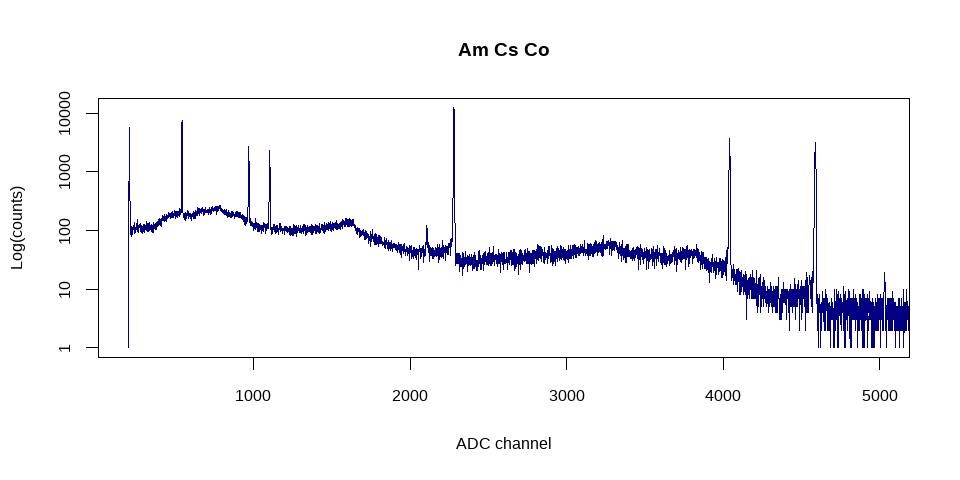

In [3]:
set_plot_dimensions(8, 4)

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


# Additional  Information

In [4]:
ACC_energies <-c(59.5409, 661.657, 1173.228, 1332.492)
df_ACC <- data.frame(ACC_energies)
row.names(df_ACC)<-c("Am","Cs","Co_1","Co_2")
df_ACC


,ACC_energies
,<dbl>
Am,59.5409
Cs,661.6570
Co_1,1173.2280
Co_2,1332.4920


## Peak detection and characterization

# !@#$%^&^%$#!@#%@$%@#^@#%@#$@#@ This has been updated !@#%^&*&^#@#%^&*&^%@$!@

Make sure to check the arguments of ```probe_peaks```

In [5]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}
############ New function ##############
grab_peak <- function(segment, data, peak_width){
    
    #finds the Ch corresponding to the maximum no. of counts
    peak_ch <- filter(segment, counts == max(counts))$Ch
    
    #slices the original dataframe symmetrically around the channel found with filter()
    peak_data <- data[(peak_ch - peak_width%/%2):(peak_ch + peak_width%/%2),]
    return(peak_data)
}


probe_peaks <- function(data, search_width, pk_size, peak_width = 20){

    peaks_list <- NULL
    counter <- 0
    for(i in seq(0, length(data$counts) - search_width, search_width)){
        
        #set up a data segment of (search_width) points to search over
        segment <- data[i:(i + search_width),]
        
        #Convert to log in case the count is too large
        log_counts <- sapply(segment$counts, log)
        
        segment$counts[which(!is.finite(log_counts))] <- 0
        #Check if data segment exceeds threshold
        if(log(range_size(segment$counts) ) < log(pk_size)){
            next
        }
        else{
            counter <- counter + 1
            
            #Make list of data.frame elements
            peaks_list[[counter]] <- grab_peak(segment, data, peak_width)
            #Rename each pair of data.frame columns appended to the list Xcounter and Ycounter
            colnames(peaks_list[[counter]]) <- c(paste('X', counter, sep = ''), paste('Y', counter, sep = ''))
        }
    }
    #bind all columns in the list together into a single dataframe
    centered_peaks <- bind_cols(peaks_list)
    return(centered_peaks)
}
########### New function ###########
convert_to_list <- function(pk_df){
    pk_list <- list()
    counter <- 0
    for(i in seq(1, length(pk_df),2)){
        counter <- counter + 1
        t <- NULL
        t$x <- pk_df[[i]][pk_df$Y1!=0]
        t$y <- pk_df[[i+1]][pk_df$Y1!=0]
        pk_list[[counter]] <- t    
    }
    return(pk_list)
}
########### New function ###########
plot_peaks <- function(peaks_df){
    the_plot <- ggplot(data = peaks_df)
    x_vars <- NULL; y_vars <- NULL
    for(name in colnames(peaks_df)){
        if(strsplit(name, '')[[1]][[1]]== 'X'){
            x_vars <- c(x_vars, name)
        }
        else if(strsplit(name, '')[[1]][[1]] == 'Y'){
            y_vars <- c(y_vars, name)
        }
    }
    for(i in seq_along(x_vars)){
        the_plot <- the_plot + geom_line(aes_string(x = x_vars[i],y = y_vars[i]))
    }
    the_plot <- the_plot + xlab('Ch') + ylab('counts')
    return(the_plot)
}
centered_peaks <- probe_peaks(data_ACC, 80, 3500)

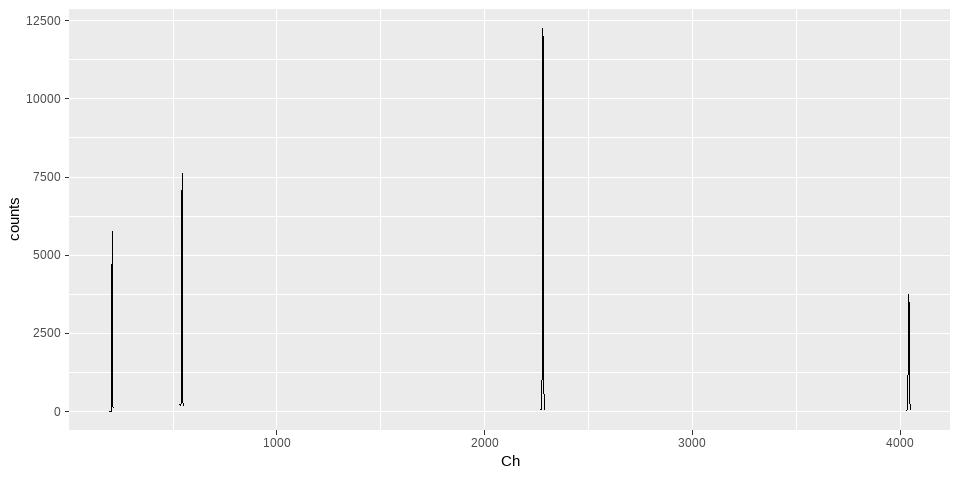

In [6]:
acc_plot <- plot_peaks(centered_peaks)
acc_plot

# Peak processing 

In [7]:
peaks <- convert_to_list(centered_peaks)

In [8]:
peaks

[[1]]
[[1]]$x
 [1] 198 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215

[[1]]$y
 [1]    1    1    3   48  328 1458 3690 5758 4707 2114  568  181   90   95   98
[16]   97   85


[[2]]
[[2]]$x
 [1] 535 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552

[[2]]$y
 [1]  227  205  256  547 1570 3904 6510 7626 5680 2856 1074  386  210  193  189
[16]  184  164


[[3]]
[[3]]$x
 [1] 2272 2274 2275 2276 2277 2278 2279 2280 2281 2282 2283 2284 2285 2286 2287
[16] 2288 2289

[[3]]$y
 [1]    96   219   586  1400  3304  6290  9826 12254 11765  8721  5231  2355
[13]   899   272    70    48    43


[[4]]
[[4]]$x
 [1] 4034 4036 4037 4038 4039 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049
[16] 4050 4051

[[4]]$y
 [1]  128  434  777 1528 2232 3065 3683 3748 3275 2357 1484  817  378  131   59
[16]   32   21

In [9]:
#Using JAGS to estimate statistical properties of the peaks
peak_properties <- function (peaks, likelihood_str, priors_str){
    i=1
    chains <-c()
    x0_mean <-c()
    x0_std <-c()
    w_mean <-c()
    w_std <-c()

    for (pk in peaks){

        #Plot of the choosen peak
        set_plot_dimensions(4, 4)
        plot(pk$x,pk$y, type="l",
            pch = 1, cex=0.5, col="navy",
            ylab = "Log(counts)", xlab ="ADC channel",
            main=paste("peak",i))

        A.min <- min(pk$y)
        A.max <- max(pk$y)
        B.min <- 0
        B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                             #a stable noise around so min(pk$y) is not representative
        x0.min <- min(pk$x)  
        x0.max <- max(pk$x)

        cat("model{

            #The likelihood: 

",likelihood_str,"

            # Priors for  A, B, x0, w 

",priors_str(A.min,A.max, B.max, x0.min, x0.max),"
}", sep = '', file=paste("Models/model_peak_",i,".bug",sep=""))

        model <- paste("Models/model_peak_",i,".bug",sep="")


        #If multiple chains are run, each of them need to be initialized
        init <- NULL;init$A  <- (A.max-A.min)/2
        init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

        #To have absolute control we also set the seed for and random number generator for each chain
        init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
                     c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
                     c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


        chain_number <- 3
        burnin       <- 1000
        iterations   <- 1.e4
        thining      <- 10


        jm <- jags.model(model,
                         pk,
                         inits=init,
                         n.chains=chain_number,
                         quiet=TRUE)

        #Update the Markov chain (Burn-in)
        update(jm, burnin)

        chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
        chains <- append(chains,list(chain))
        #Generate the chain and posterior plots
        options(repr.plot.width = 10, repr.plot.height = 10)
        #plot(chain)
        print(paste("peak",i))
        print(summary(chain))

        A  <- summary(chain)$statistics[1]
        B  <- summary(chain)$statistics[2]
        w  <- summary(chain)$statistics[3]
        x0  <- summary(chain)$statistics[4]
        x0_mean <- c(x0_mean,x0)
        x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
        w_mean <- c(w_mean,w)
        w_std  <- c(w_std,summary(chain)$statistics[3,2])

        x <- seq(x0.min,x0.max,0.25)
        f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


        set_plot_dimensions(4, 4)
        plot(pk$x,pk$y,
            ylab = "Counts", xlab ="ADC channel",
            main=paste("peak",i))
        lines(x,f, lwd=2, col='firebrick3')
        i=i+1
    }

    results <- NULL
    results$chains  <- chains
    results$x0_mean <- x0_mean
    results$x0_std  <- x0_std
    results$w_mean  <- w_mean
    results$w_std   <- w_std
        return(results)
}

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  5758.001 0.143079 0.0026123      0.0025583
B    84.714 0.317797 0.0058021      0.0057049
w     1.265 0.006144 0.0001122      0.0001122
x0  206.184 0.009844 0.0001797      0.0001838

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
A  5757.714 5757.905 5758.001 5758.09 5758.283
B    84.080   84.499   84.718   84.93   85.329
w     1.254    1.261    1.265    1.27    1.278
x0  206.165  206.178  206.184  206.19  206.203



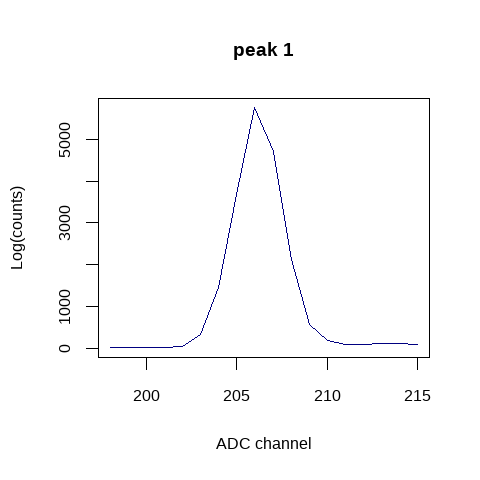

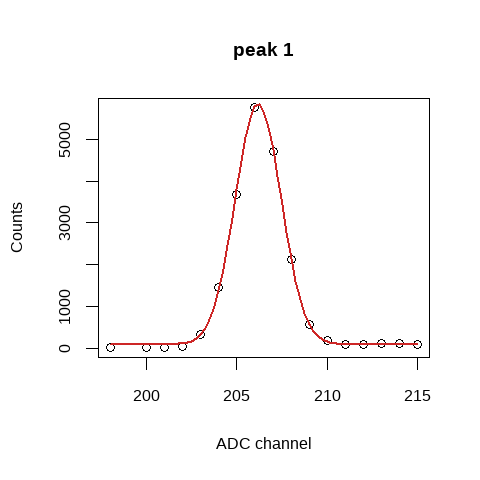

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  7625.997 0.140743 0.0025696      0.0026700
B   204.963 0.318010 0.0058060      0.0057049
w     1.514 0.005891 0.0001076      0.0001076
x0  542.816 0.009841 0.0001797      0.0001831

2. Quantiles for each variable:

       2.5%     25%      50%      75%    97.5%
A  7625.723 7625.90 7625.997 7626.094 7626.266
B   204.352  204.75  204.958  205.178  205.580
w     1.503    1.51    1.514    1.518    1.526
x0  542.796  542.81  542.816  542.822  542.835



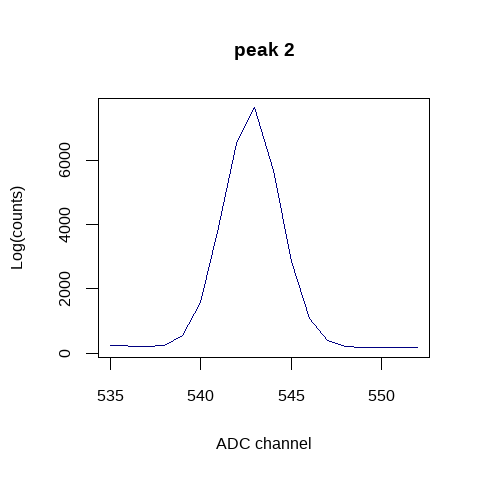

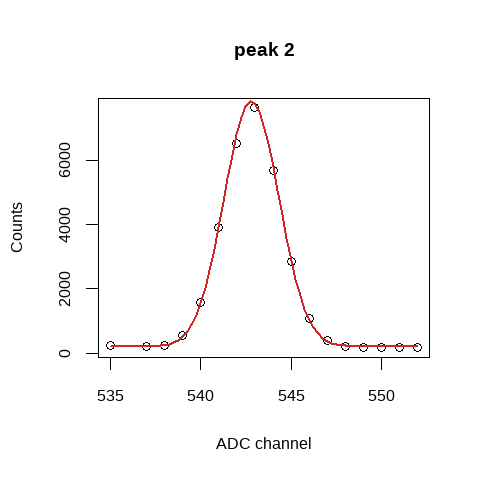

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  12254.000 0.143229 2.615e-03      2.524e-03
B     95.857 0.319872 5.840e-03      5.587e-03
w      2.018 0.005086 9.287e-05      9.286e-05
x0  2280.301 0.008540 1.559e-04      1.559e-04

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  12253.727 12253.906 12253.995 12254.095 12254.288
B     95.236    95.639    95.858    96.066    96.495
w      2.008     2.014     2.018     2.021     2.028
x0  2280.284  2280.296  2280.301  2280.307  2280.318



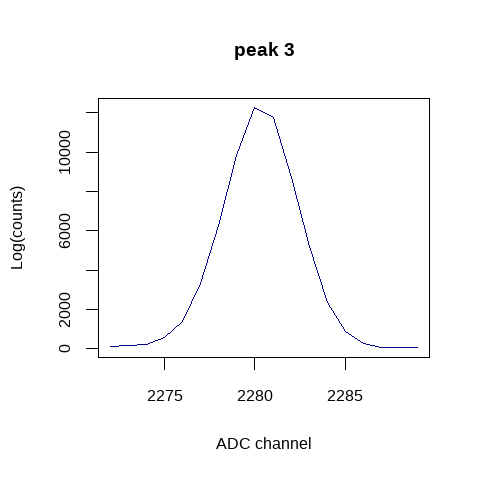

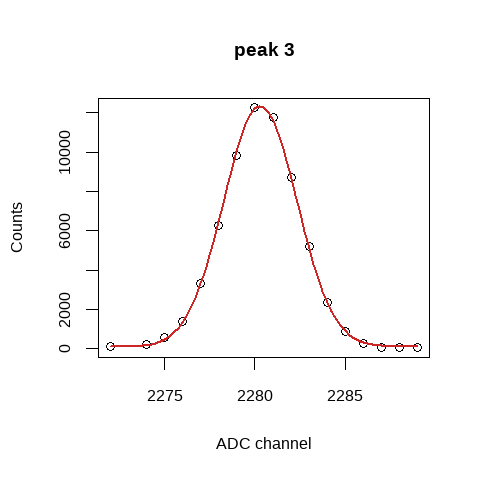

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  3748.003 0.14258 0.0026032      0.0026163
B   127.740 0.31605 0.0057702      0.0057712
w     2.393 0.01127 0.0002058      0.0002078
x0 4041.502 0.01783 0.0003255      0.0003254

2. Quantiles for each variable:

       2.5%      25%      50%    75%    97.5%
A  3747.723 3747.906 3748.004 3748.1 3748.293
B   127.122  127.526  127.737  128.0  128.371
w     2.371    2.385    2.393    2.4    2.415
x0 4041.468 4041.490 4041.503 4041.5 4041.537



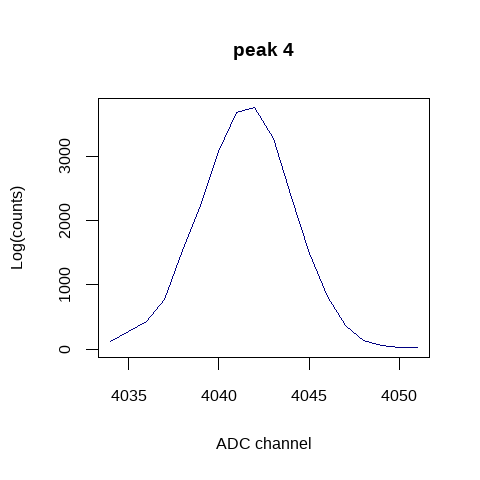

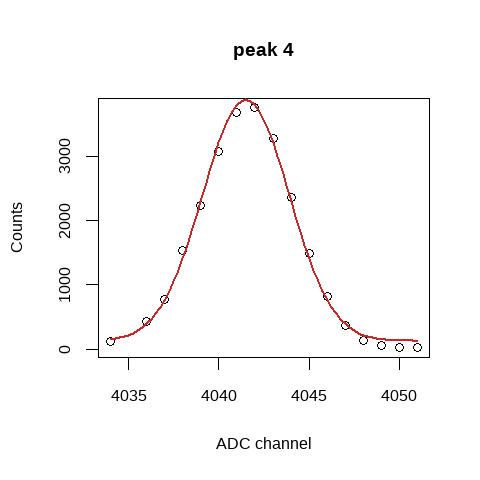

In [10]:
likelihood_str <- 'for (i in 1:length(x)){
S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)
y[i] ~ dpois(S[i])
}'
priors_str <- function(A.min, A.max, B.max, x0.min, x0.max){
    priors_str <- paste("A ~ dnorm(",A.max,",",50,")
B ~ dnorm(",B.max,",",10,")
x0 ~ dunif(",x0.min,",",x0.max,")
w ~ dunif(1,10)", sep = '')
return(priors_str)
}

ACC_properties <- peak_properties(peaks, likelihood_str, priors_str)

#### Americum

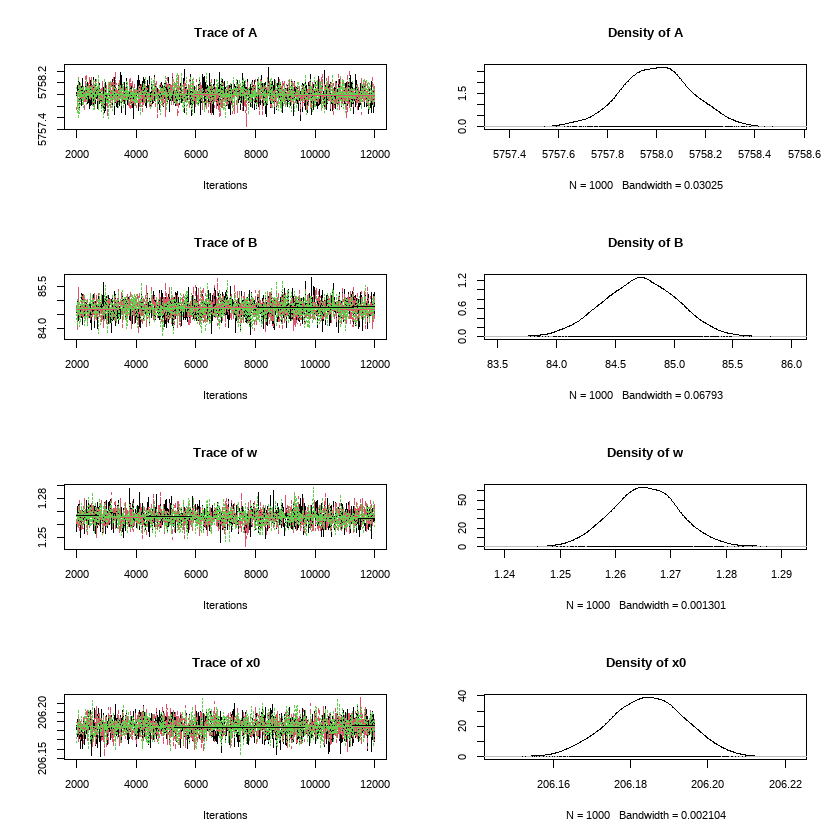

In [11]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[1]])

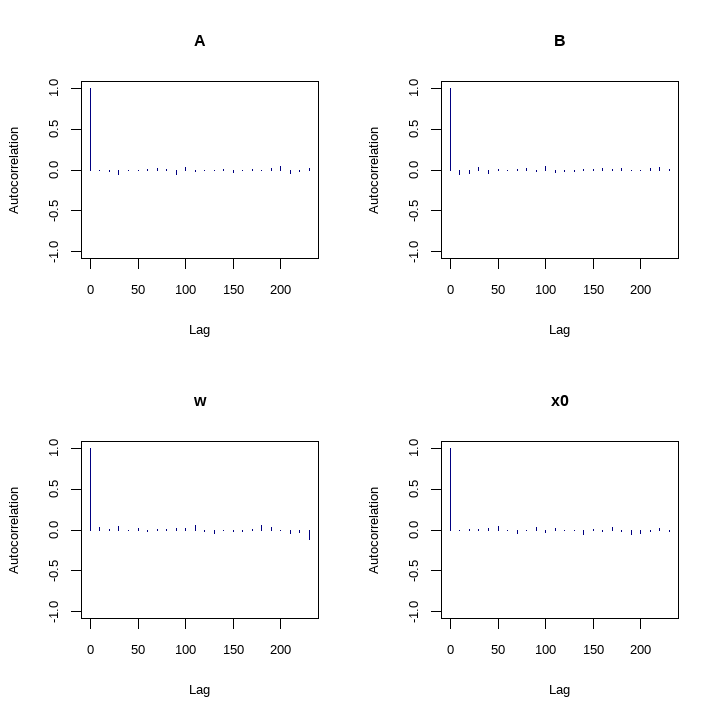

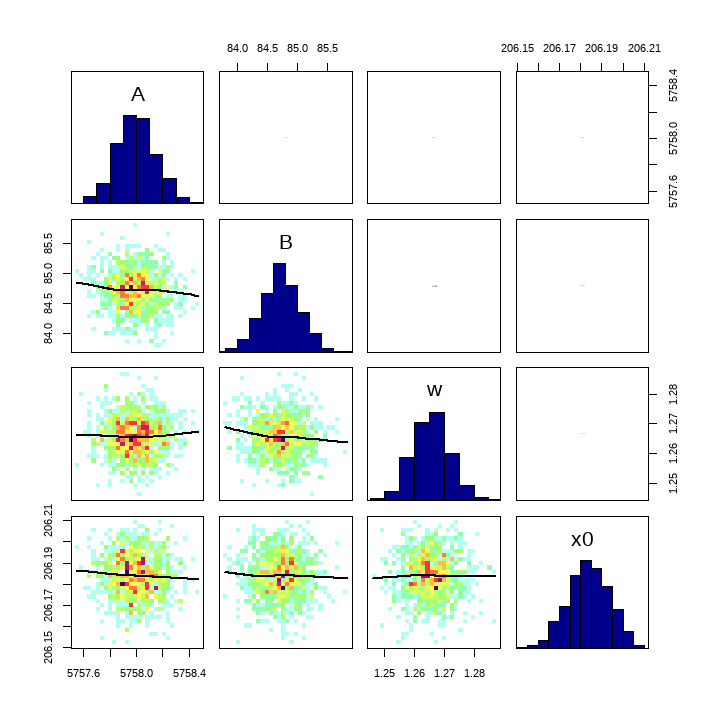

In [12]:
set_plot_dimensions(6, 6)

autocorr.plot(ACC_properties$chains[[1]][1], col='navy')
correlationPlot((ACC_properties$chains[[1]][1]))

#### Cs

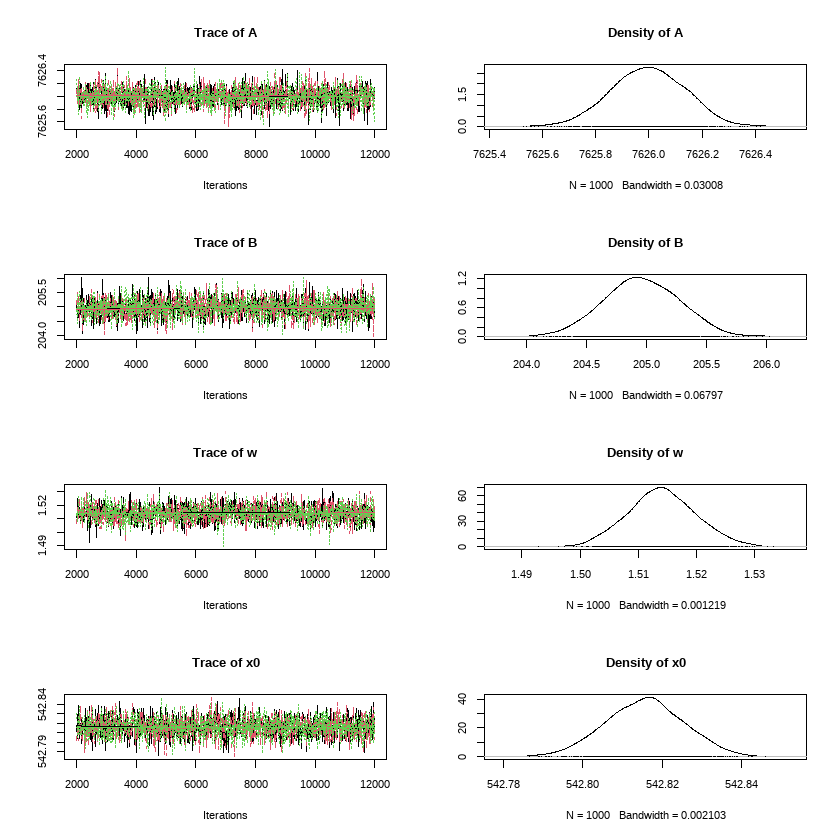

In [13]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[2]])

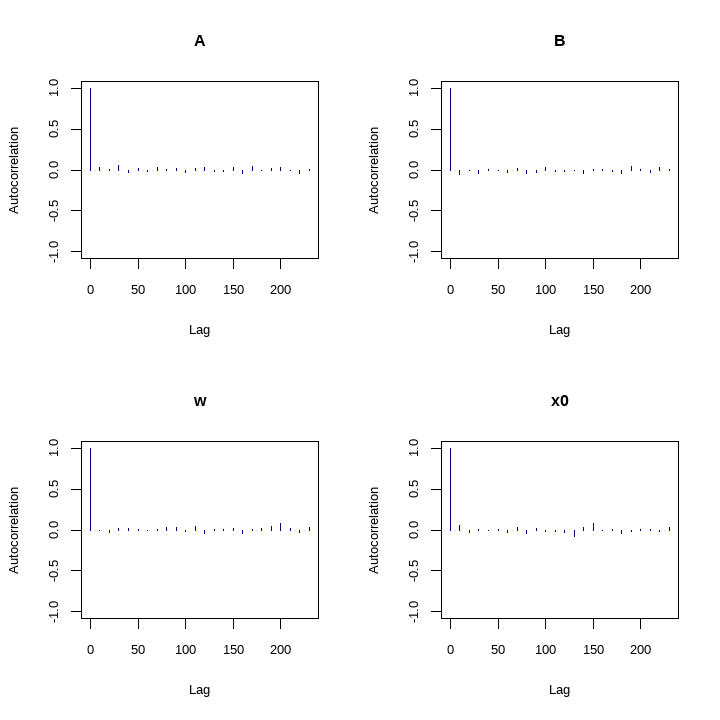

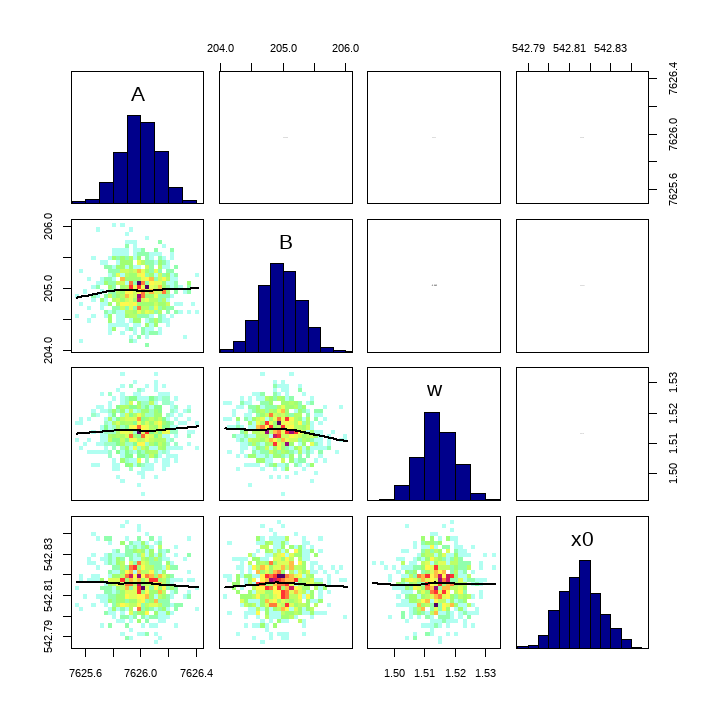

In [14]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[2]][1], col='navy')

correlationPlot((ACC_properties$chains[[2]][1]))

### Co 1

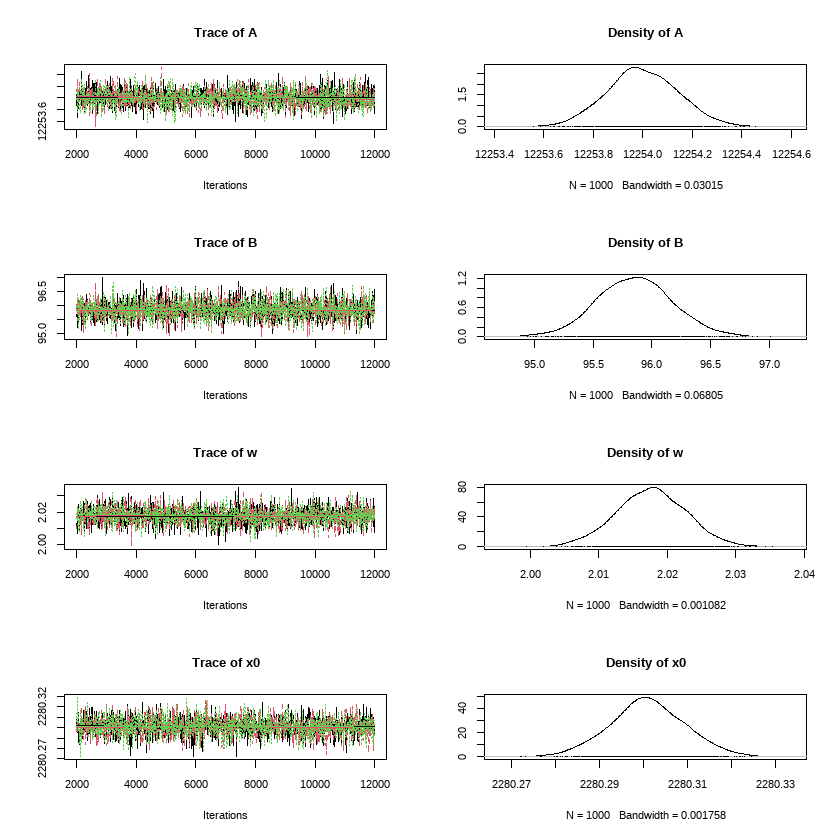

In [15]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[3]])

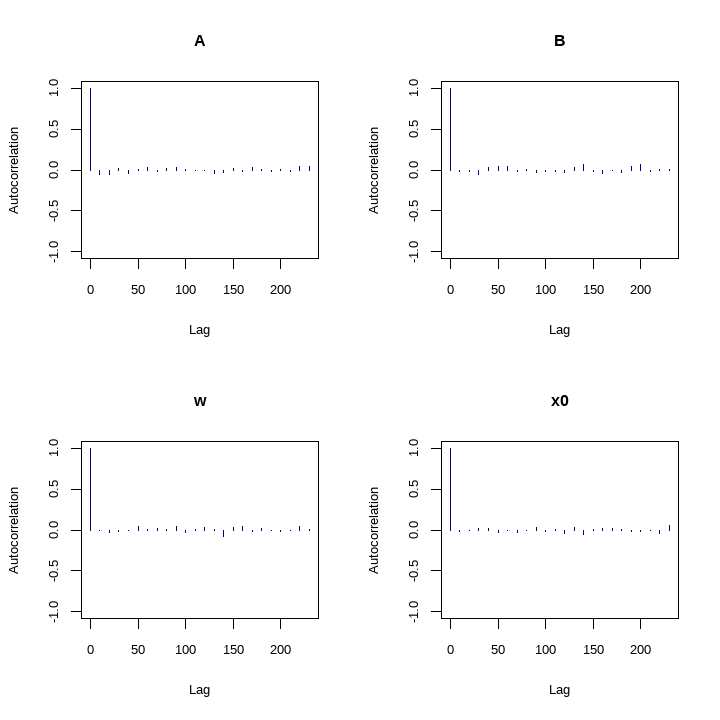

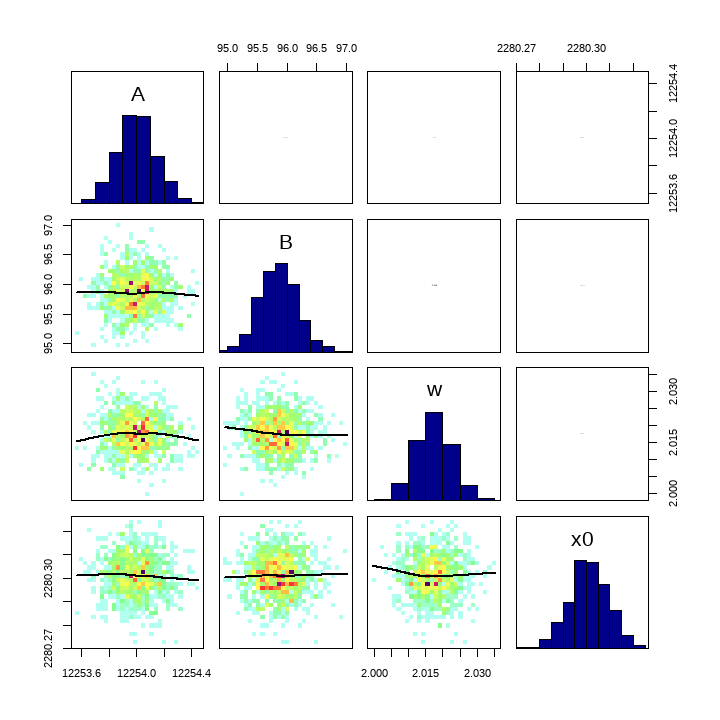

In [16]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[3]][1], col='navy')

correlationPlot((ACC_properties$chains[[3]][1]))

#### Co 2

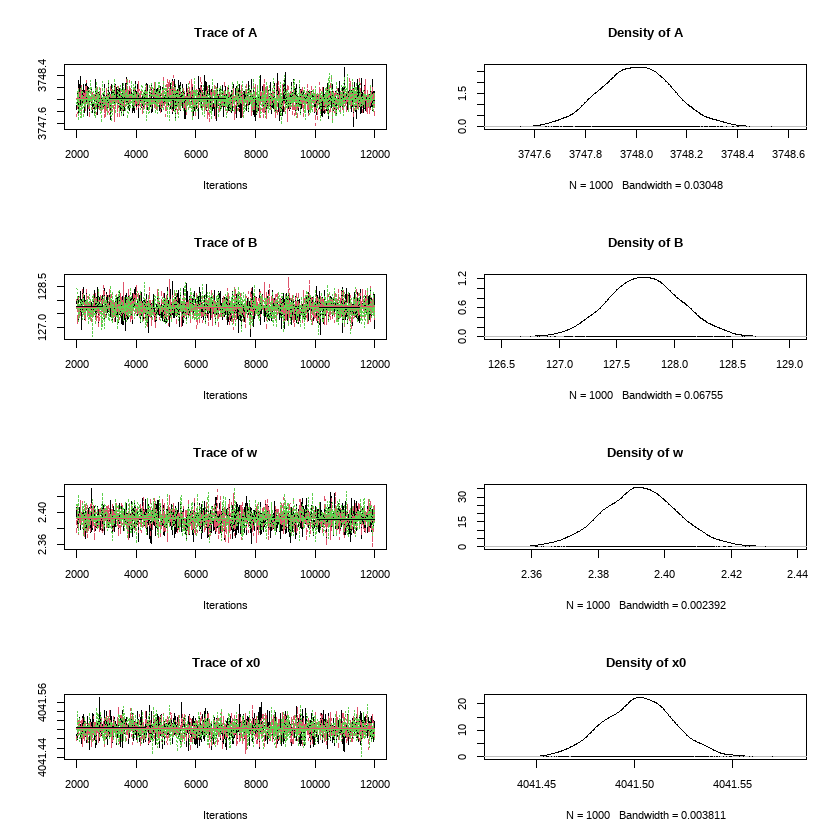

In [17]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[4]])

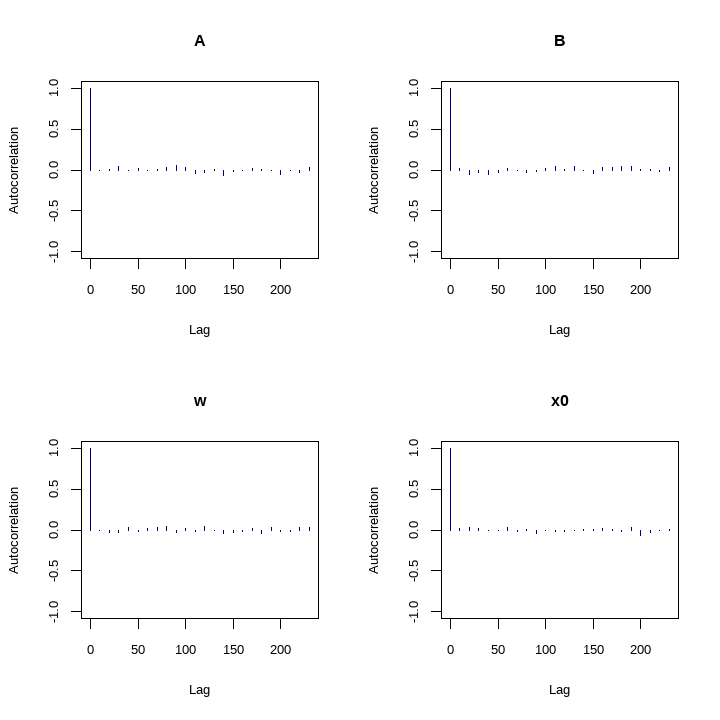

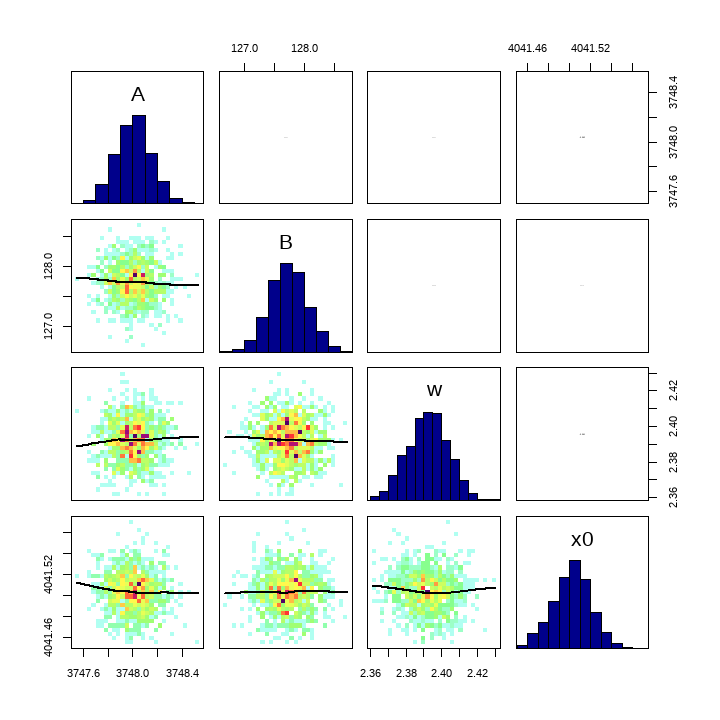

In [18]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[4]][1], col='navy')

correlationPlot((ACC_properties$chains[[4]][1]))

#### Co-3

In [19]:
# set_plot_dimensions(7, 7)
# plot(ACC_properties$chains[[5]])

In [20]:
# set_plot_dimensions(6, 6)
# autocorr.plot(ACC_properties$chains[[5]][1], col='navy')

# correlationPlot((ACC_properties$chains[[5]][1]))

## Energy calibration

In [21]:
df_ACC$x0_mean <- ACC_properties$x0_mean
df_ACC$x0_std  <- ACC_properties$x0_std
df_ACC$w_mean  <- ACC_properties$w_mean
df_ACC$w_std   <- ACC_properties$w_std


In [22]:
df_ACC

,ACC_energies,x0_mean,x0_std,w_mean,w_std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Am,59.5409,206.1842,0.009844154,1.265442,0.006143556
Cs,661.6570,542.8156,0.009841039,1.514096,0.005891158
Co_1,1173.2280,2280.3010,0.008539547,2.017656,0.005086429
Co_2,1332.4920,4041.5024,0.017830083,2.392640,0.011272728


In [23]:
linear_fit <- lm( df_ACC$ACC_energies ~ df_ACC$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
calibrated_energy <- intercept + data_ACC$Ch*slope

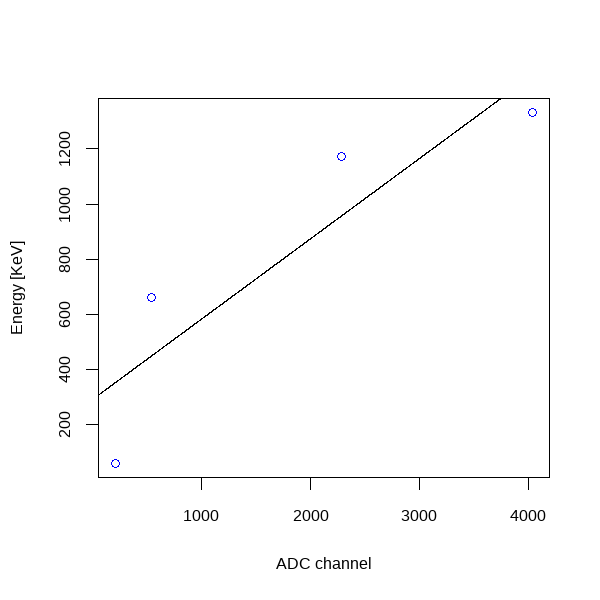

In [24]:
set_plot_dimensions(5, 5)
plot(df_ACC$x0_mean,df_ACC$ACC_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="")
lines(data_ACC$Ch,calibrated_energy)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1930 y values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1930 y values <= 0 omitted from logarithmic plot"


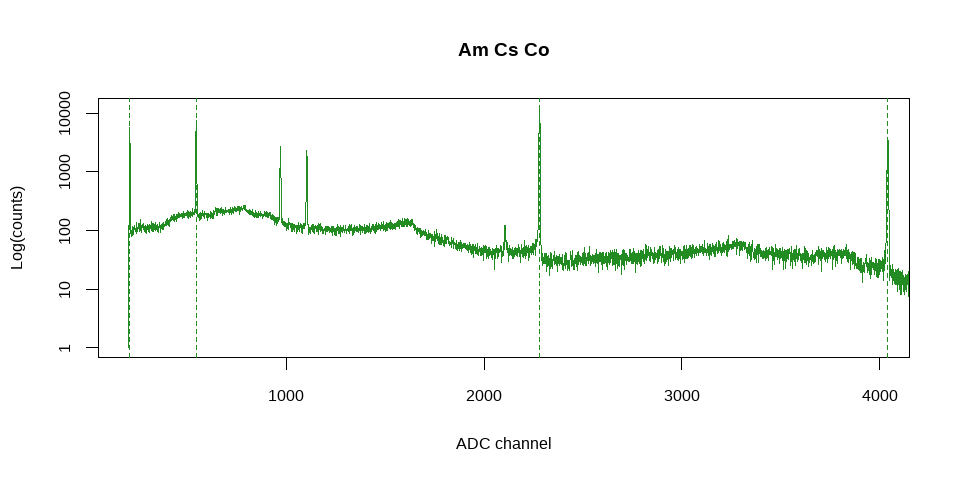

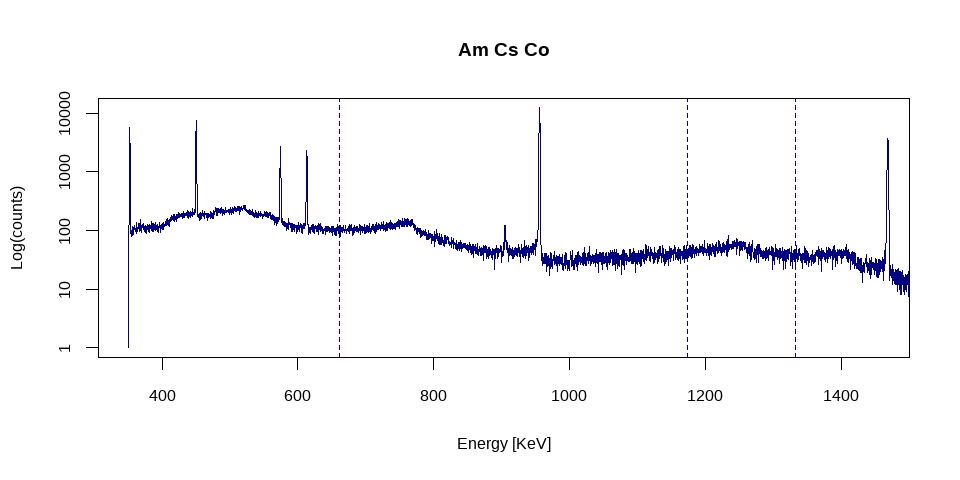

In [25]:
set_plot_dimensions(8, 4)

xmin <- 200;xmax<-4000
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in seq_along(ACC_properties$x0_mean)){
    
    abline(v=ACC_properties$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)
    }
# abline(v=ACC_properties$x0_mean[2],col="forestgreen",lty=2,lwd=0.3)
# abline(v=ACC_properties$x0_mean[3],col="forestgreen",lty=2,lwd=0.3)
# abline(v=ACC_properties$x0_mean[4],col="forestgreen",lty=2,lwd=0.3)



plot(calibrated_energy,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in seq_along(ACC_energies)){
abline(v=df_ACC$ACC_energies[i],col="navy",lty=2,lwd=0.3)
}

# abline(v=df_ACC$ACC_energies[2],col="navy",lty=2,lwd=0.3)
# abline(v=df_ACC$ACC_energies[3],col="navy",lty=2,lwd=0.3)
# abline(v=df_ACC$ACC_energies[4],col="navy",lty=2,lwd=0.3)

In [26]:
seq_along(df_ACC$ACC_energies)

[1] 1 2 3 4

# Thorium

In [27]:
data_T <- read.table("data/IC48A_Th.txt", col.names = c('Ch', 'counts')) 

As we don't know which are the peaks to use we cheated, there is a paper from Baudis et.al https://arxiv.org/pdf/1508.05731.pdf with the spectrum from Th in a Germanium detector and there the peaks are identified so we picked two of them which were clearly the same as in our spectrum and used them to "calibrate the energy". We used this information to identify the peaks in our spectrum.

The 511 energy peak is between the channels 3150,3250 centered at 3215

The 2614 energy peak is between the channels 16200,16600 centered at 16450

As the lines we plotted clearly fit existing peaks, we trust that we are picking the correct ones. 

In [38]:
T_energies <-c(238.632,300.089,510.74,583.187,727.330,763.45,785.37,860.53)#,893.408,1078.63,1512.70,1592.511) #,1620.738,2103.511,2614.511)
df_T <- data.frame(T_energies)
row.names(df_T)<-c("Th 1","Th 2","Th 3","Th 4","Th 5","Th 6","Th 7", "Th 8")#, "Th 9", "Th 10", "Th 11", "Th 12")#, "Th 13", "Th 14", "Th 15")
df_T

,T_energies
,<dbl>
Th 1,238.632
Th 2,300.089
Th 3,510.740
Th 4,583.187
Th 5,727.330
Th 6,763.450
Th 7,785.370
Th 8,860.530


In [39]:
ch1<-3215;en1<-511
ch2<-16450;en2<-2614
b<-(ch1-ch2)/(en1-en2)
a<-ch1-en1*b
ch_th <- a+ df_T$T_energies *b

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4435 y values <= 0 omitted from logarithmic plot"


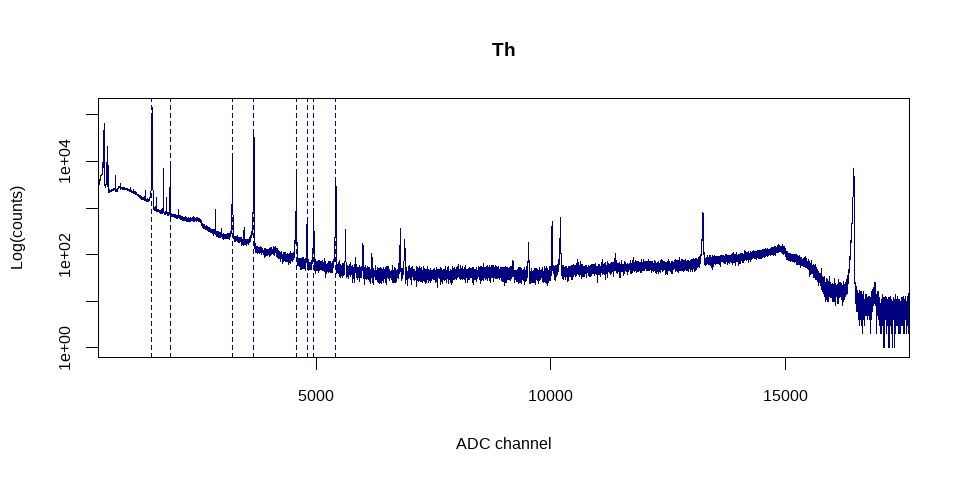

In [40]:
set_plot_dimensions(8, 4)

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in seq_along(ch_th)){
    abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)
}

In [41]:
# th_1 <- NULL
# th_1$x <- data_T$Ch[1450:1550]
# th_1$y <- data_T$counts[1450:1550]

# th_2 <- NULL
# th_2$x <- data_T$Ch[1850:1950]
# th_2$y <- data_T$counts[1850:1950]

# th_3 <- NULL
# th_3$x <- data_T$Ch[3100:3300]
# th_3$y <- data_T$counts[3100:3300]

# th_4 <- NULL
# th_4$x <- data_T$Ch[3600:3750]
# th_4$y <- data_T$counts[3600:3750]

# th_5 <- NULL
# th_5$x <- data_T$Ch[4500:4650]
# th_5$y <- data_T$counts[4500:4650]

# th_6 <- NULL
# th_6$x <- data_T$Ch[4750:4850]
# th_6$y <- data_T$counts[4750:4850]

# th_7 <- NULL
# th_7$x <- data_T$Ch[4900:5000]
# th_7$y <- data_T$counts[4900:5000]

# th_8 <- NULL
# th_8$x <- data_T$Ch[5350:5475]
# th_8$y <- data_T$counts[5350:5475]

# th_9 <- NULL
# th_9$x <- data_T$Ch[5600:5650]
# th_9$y <- data_T$counts[5600:5650]

# th_10 <- NULL
# th_10$x <- data_T$Ch[6750:6850]
# th_10$y <- data_T$counts[6750:6850]

# th_11 <- NULL
# th_11$x <- data_T$Ch[9500:9550]
# th_11$y <- data_T$counts[9500:9550]

# th_12 <- NULL
# th_12$x <- data_T$Ch[10000:10060]
# th_12$y <- data_T$counts[10000:10060]

# th_13 <- NULL
# th_13$x <- data_T$Ch[10150:10250]
# th_13$y <- data_T$counts[10150:10250]

# th_14 <- NULL
# th_14$x <- data_T$Ch[13150:13300]
# th_14$y <- data_T$counts[13150:13300]

# th_15 <- NULL
# th_15$x <- data_T$Ch[16200:16600]
# th_15$y <- data_T$counts[16200:16600]


# th_peaks <-list(th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15)

In [42]:
T_peaks <- probe_peaks(data_T, 60, 8000)
th_peaks <- convert_to_list(T_peaks)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4435 y values <= 0 omitted from logarithmic plot"


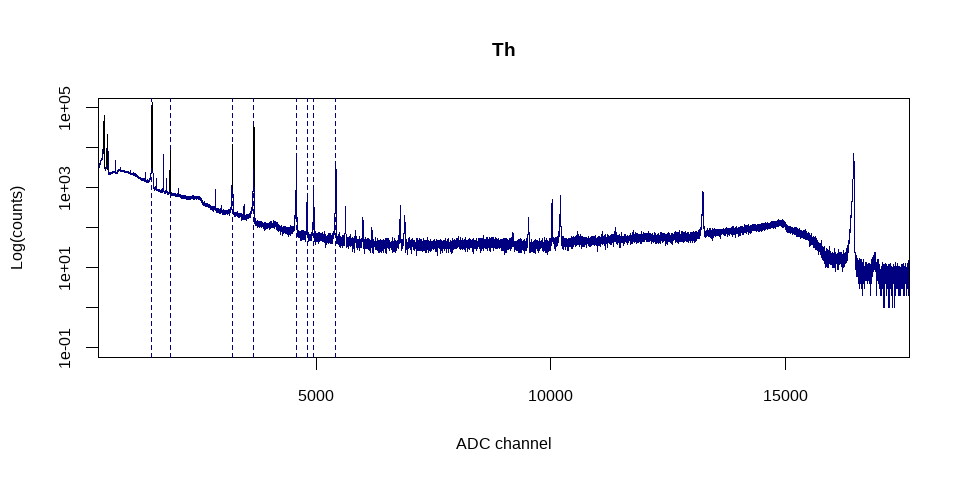

In [43]:
#Just to control we are picking the right ones
plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),ylim=c(1.e-1,1.e5),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")

for(i in seq_along(ch_th)){
    abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)
}

for(peak in th_peaks){
    lines(peak)
}

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
A  46019.992 0.14184 2.590e-03      2.623e-03
B   7945.071 0.31631 5.775e-03      5.656e-03
w      1.947 0.00390 7.121e-05      7.121e-05
x0   470.621 0.00599 1.094e-04      1.083e-04

2. Quantiles for each variable:

       2.5%       25%       50%      75%     97.5%
A  46019.72 46019.893 46019.993 46020.09 46020.269
B   7944.44  7944.857  7945.072  7945.28  7945.702
w      1.94     1.945     1.947     1.95     1.955
x0   470.61   470.617   470.621   470.62   470.633



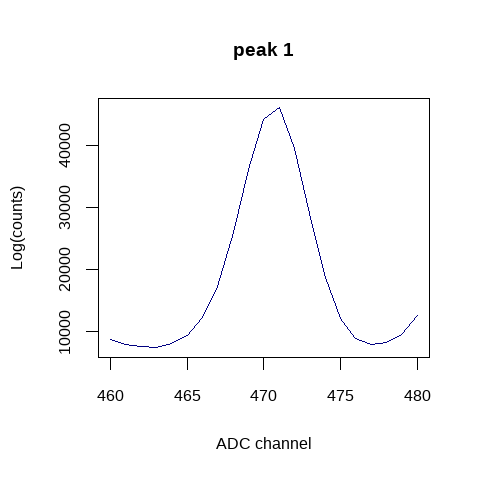

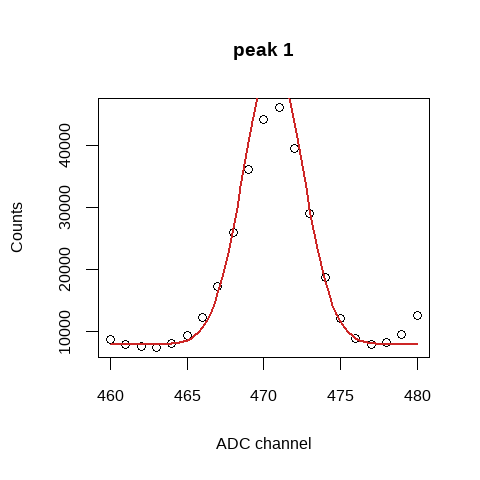

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  64517.994 0.140290 2.561e-03      2.626e-03
B   7944.972 0.314246 5.737e-03      5.737e-03
w      1.928 0.002919 5.329e-05      5.331e-05
x0   484.814 0.004507 8.229e-05      8.285e-05

2. Quantiles for each variable:

        2.5%       25%       50%      75%     97.5%
A  64517.724 64517.899 64517.992 64518.09 64518.267
B   7944.358  7944.764  7944.967  7945.18  7945.605
w      1.922     1.926     1.928     1.93     1.934
x0   484.805   484.811   484.814   484.82   484.823



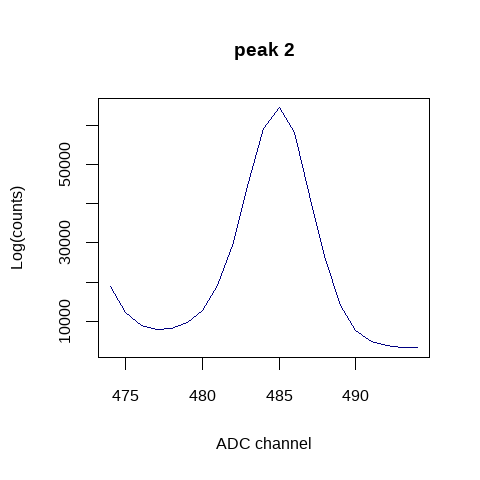

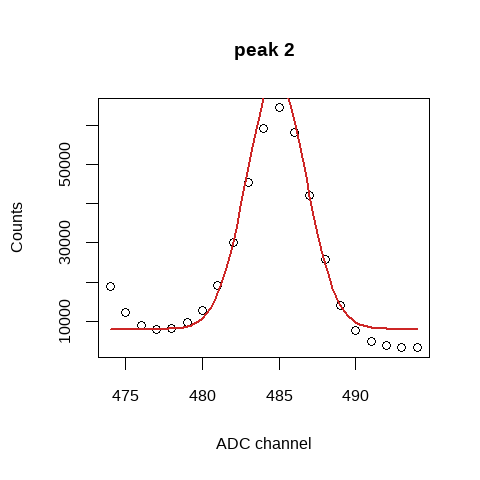

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  21323.987 0.142936 0.0026096      0.0026086
B   3775.896 0.320217 0.0058463      0.0058473
w      2.474 0.006307 0.0001152      0.0001152
x0   548.190 0.009803 0.0001790      0.0001778

2. Quantiles for each variable:

        2.5%      25%       50%       75%     97.5%
A  21323.706 21323.89 21323.985 21324.087 21324.268
B   3775.270  3775.68  3775.893  3776.121  3776.530
w      2.462     2.47     2.474     2.478     2.486
x0   548.171   548.18   548.191   548.197   548.209



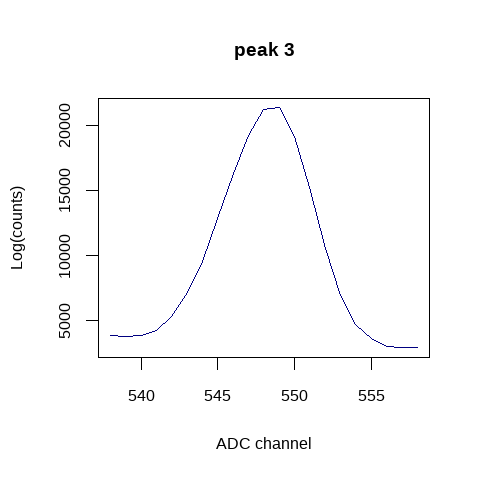

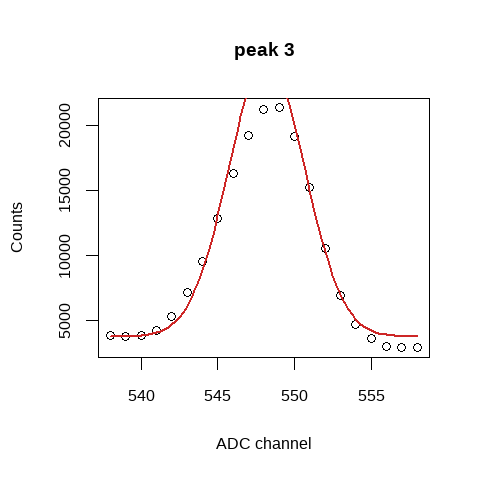

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  1.403e+05 0.141668 2.586e-03      2.587e-03
B  1.364e+04 0.312397 5.704e-03      5.705e-03
w  2.229e+00 0.002061 3.763e-05      3.763e-05
x0 1.503e+03 0.003219 5.877e-05      5.864e-05

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  1.403e+05 1.403e+05 1.403e+05 1.403e+05 1.403e+05
B  1.364e+04 1.364e+04 1.364e+04 1.364e+04 1.364e+04
w  2.225e+00 2.228e+00 2.229e+00 2.231e+00 2.234e+00
x0 1.503e+03 1.503e+03 1.503e+03 1.503e+03 1.503e+03



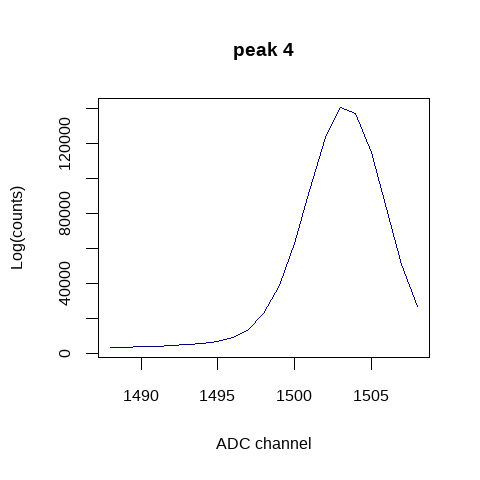

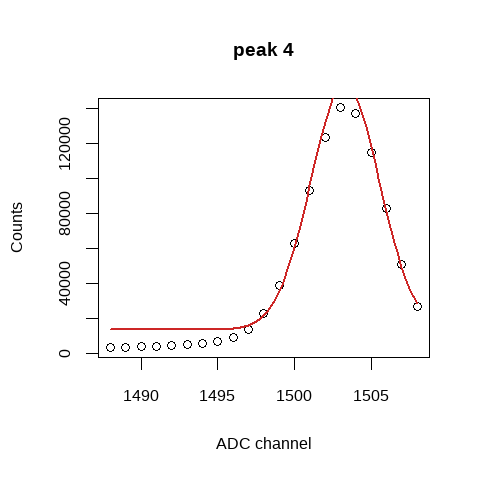

[1] "peak 5"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  1.403e+05 0.142892 2.609e-03      2.610e-03
B  4.747e+03 0.319027 5.825e-03      5.817e-03
w  2.503e+00 0.001807 3.299e-05      3.299e-05
x0 1.503e+03 0.002962 5.407e-05      5.408e-05

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  1.403e+05 1.403e+05 1.403e+05 1.403e+05 1.403e+05
B  4.746e+03 4.747e+03 4.747e+03 4.747e+03 4.748e+03
w  2.499e+00 2.501e+00 2.503e+00 2.504e+00 2.506e+00
x0 1.503e+03 1.503e+03 1.503e+03 1.503e+03 1.503e+03



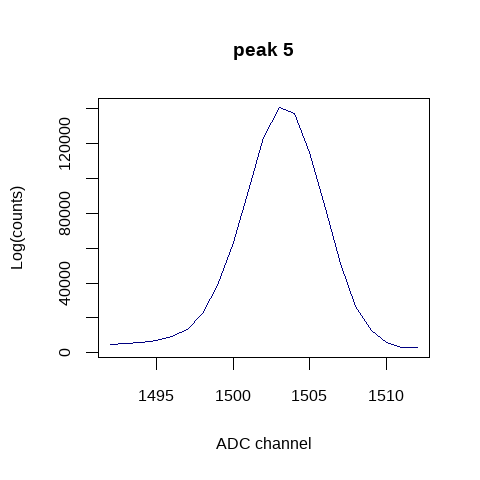

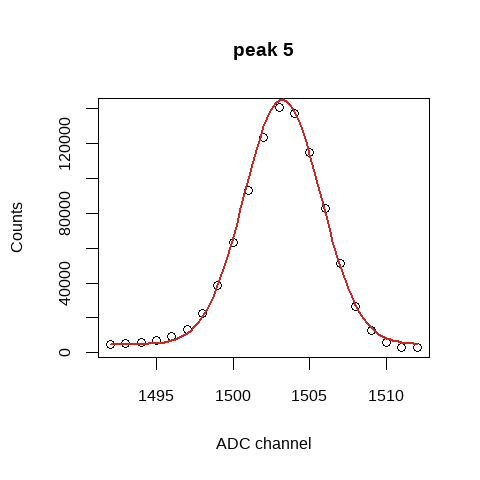

[1] "peak 6"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  8897.993 0.139105 0.0025397      0.0025394
B   925.005 0.308513 0.0056327      0.0055443
w     2.584 0.009068 0.0001656      0.0001598
x0 1890.196 0.013946 0.0002546      0.0002592

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
A  8897.717 8897.900 8897.990 8898.09 8898.263
B   924.379  924.798  925.008  925.22  925.597
w     2.566    2.578    2.584    2.59    2.602
x0 1890.169 1890.187 1890.196 1890.21 1890.223



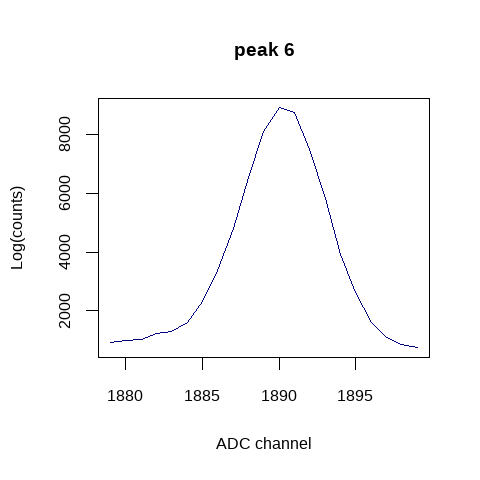

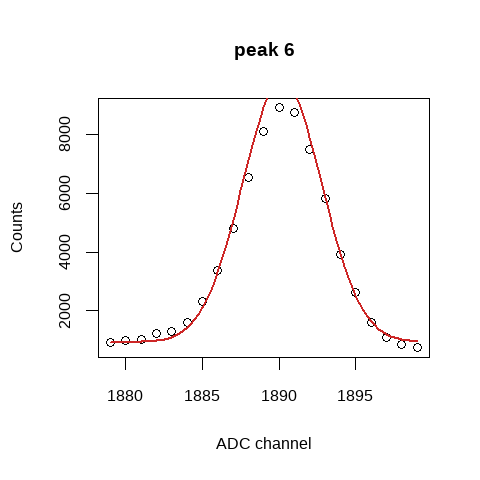

[1] "peak 7"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  12095.000 0.142165 0.0025956      0.0025775
B   1278.946 0.316078 0.0057708      0.0058781
w      3.141 0.008404 0.0001534      0.0001469
x0  3216.409 0.013247 0.0002419      0.0002442

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  12094.728 12094.902 12094.999 12095.103 12095.273
B   1278.338  1278.730  1278.941  1279.156  1279.567
w      3.125     3.135     3.141     3.147     3.158
x0  3216.383  3216.401  3216.409  3216.418  3216.435



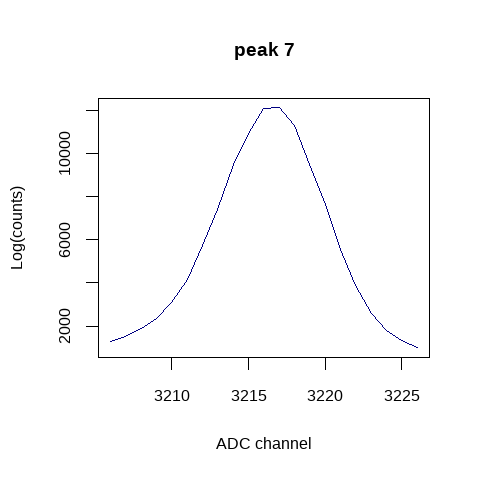

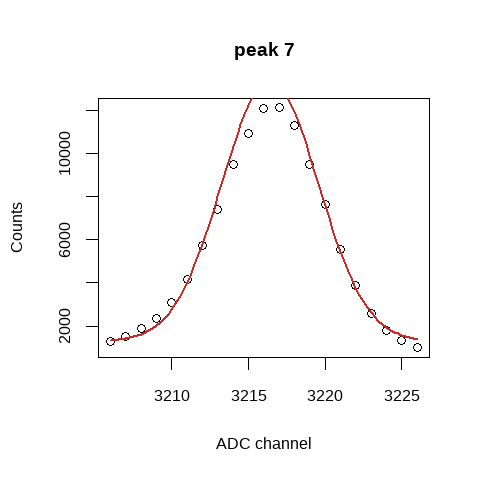

[1] "peak 8"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A  37494.996 0.140595 2.567e-03      2.601e-03
B   3034.907 0.320169 5.845e-03      5.760e-03
w      3.164 0.004473 8.167e-05      8.372e-05
x0  3672.553 0.007057 1.289e-04      1.210e-04

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
A  37494.710 37494.902 37494.998 37495.093 37495.261
B   3034.280  3034.699  3034.905  3035.113  3035.540
w      3.155     3.161     3.164     3.167     3.173
x0  3672.539  3672.548  3672.553  3672.558  3672.567



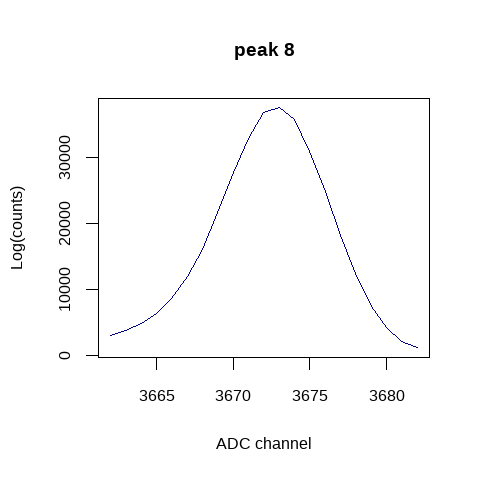

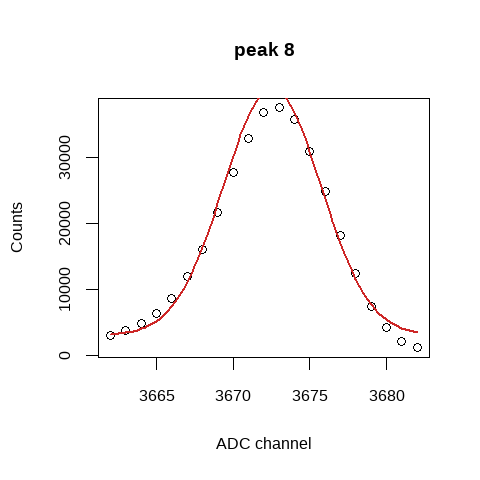

In [46]:
T_properties <- peak_properties(th_peaks, likelihood_str, priors_str)

In [47]:
# i=1
# chains <-c()
# x0_mean <-c()
# x0_std <-c()
# w_mean <-c()
# w_std <-c()

# for (pk in th_peaks){

# #Plot of the choosen peak
# set_plot_dimensions(4, 4)
# plot(pk$x,pk$y, type="l",
#     pch = 1, cex=0.5, col="navy",
#     ylab = "Log(counts)", xlab ="ADC channel",
#     main=paste("peak",i))

# A.min <- min(pk$y)
# A.max <- max(pk$y)
# B.min <- 0
# B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
#                      #a stable noise around so min(pk$y) is not representative
# x0.min <- min(pk$x)  
# x0.max <- max(pk$x)

# cat("model{

#     #The likelihood:

#     for (i in 1:length(x)){
#         S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

#         y[i] ~ dpois(S[i]) 
#     } 


#     # Priors for  A, B, x0, w

#     A ~ dnorm(",A.max,",",50,")
#     B ~ dnorm(",B.max,",",10,")

#     x0 ~ dunif(",x0.min,",",x0.max,")
#     w ~ dunif(1,10)
      
# }", file=paste("Models/model_peak_",i,".bug",sep=""))

# model <- paste("Models/model_peak_",i,".bug",sep="")


# #If multiple chains are run, each of them need to be initialized
# init <- NULL;init$A  <- (A.max-A.min)/2
# init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

# #To have absolute control we also set the seed for and random number generator for each chain
# init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
#              c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
#              c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


# chain_number <- 3
# burnin       <- 1000
# iterations   <- 1.e4
# thining      <- 10


# jm <- jags.model(model,
#                  pk,
#                  inits=init,
#                  n.chains=chain_number,
#                  quiet=TRUE)

# #Update the Markov chain (Burn-in)
# update(jm, burnin)

# chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
# chains <- append(chains,list(chain))

# #Generate the chain and posterior plots
# options(repr.plot.width = 10, repr.plot.height = 10)
# #plot(chain)
# print(paste("peak",i))
# print(summary(chain))

# A  <- summary(chain)$statistics[1]
# B  <- summary(chain)$statistics[2]
# w  <- summary(chain)$statistics[3]
# x0  <- summary(chain)$statistics[4]
# x0_mean <- c(x0_mean,x0)
# x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
# w_mean <- c(w_mean,w)
# w_std  <- c(w_std,summary(chain)$statistics[3,2])
    
# x <- seq(x0.min,x0.max,0.25)
# f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


# set_plot_dimensions(4, 4)
# plot(pk$x,pk$y,
#     ylab = "Counts", xlab ="ADC channel",
#     main=paste("peak",i))
# lines(x,f, lwd=2, col='firebrick3')
# i=i+1
# }

### Energy calibration

In [79]:
df_T$x0_mean <- T_properties$x0_mean
df_T$x0_std  <- T_properties$x0_std
df_T$w_mean  <- T_properties$w_mean
df_T$w_std   <- T_properties$w_std


#df <- data.frame(energy_th,x0_mean,x0_std)
#row.names(df)<-c("Th 1","Th 2","Th 3","Th 4","Th 5","Th 6","Th 7", "Th 8", "Th 9", "Th 10", "Th 11",
#                "Th 12", "Th 13", "Th 14", "Th 15")

In [49]:
df_T

,T_energies,x0_mean,x0_std,w_mean,w_std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Th 1,238.632,470.6207,0.005989543,1.947391,0.003900489
Th 2,300.089,484.8137,0.004507400,1.927931,0.002918701
Th 3,510.740,548.1902,0.009802745,2.473829,0.006307459
Th 4,583.187,1503.3001,0.003219122,2.229446,0.002061011
Th 5,727.330,1503.2154,0.002961571,2.502589,0.001806955
Th 6,763.450,1890.1960,0.013946303,2.584175,0.009067792
Th 7,785.370,3216.4092,0.013246838,3.141129,0.008404356
Th 8,860.530,3672.5532,0.007057414,3.163945,0.004473077


In [50]:
linear_fit <- lm( df_T$T_energies ~ df_T$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
calibrated_energy <- intercept + data_T$Ch*slope

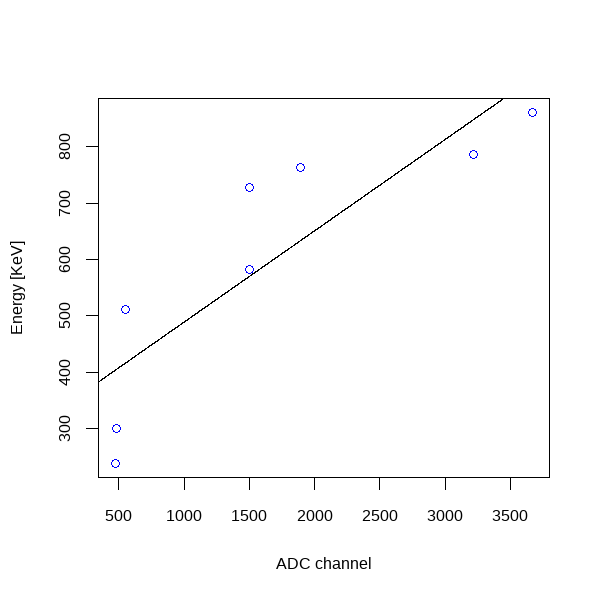

In [51]:
set_plot_dimensions(5, 5)
plot(df_T$x0_mean,df_T$T_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="")
lines(data_T$Ch,calibrated_energy)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4435 y values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4435 y values <= 0 omitted from logarithmic plot"


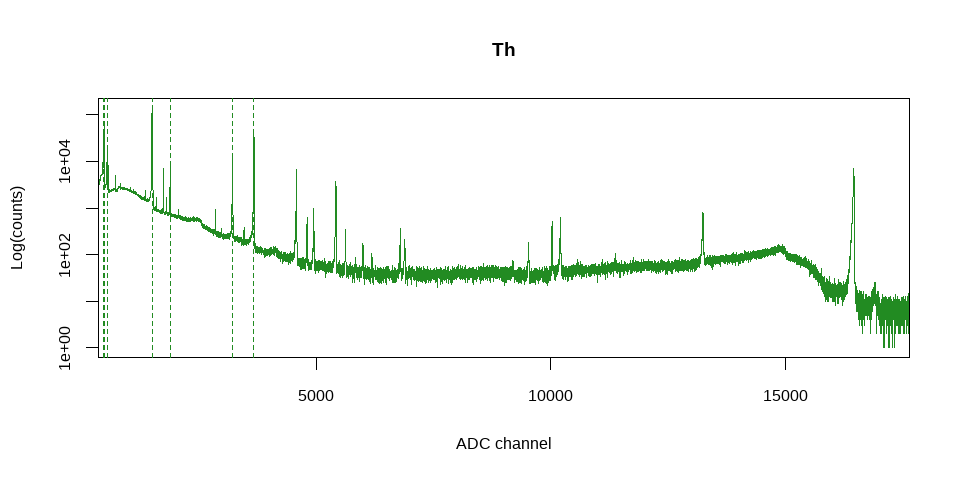

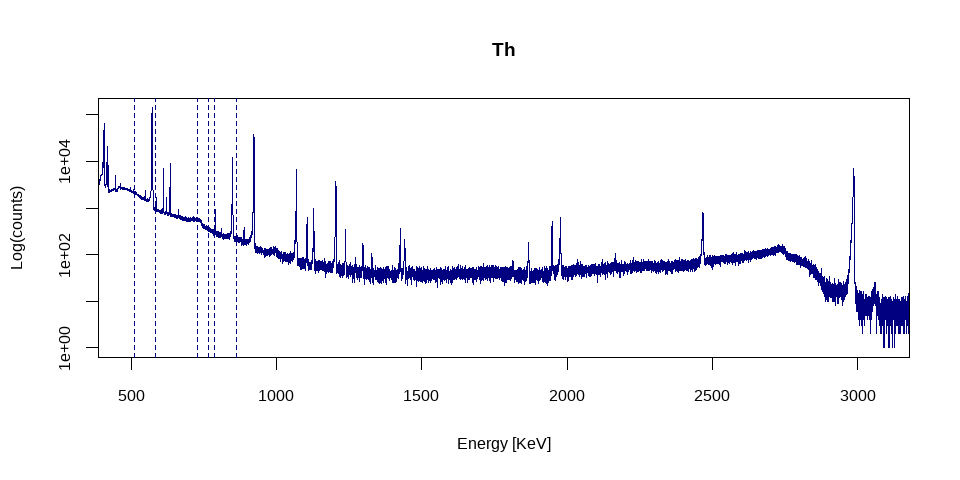

In [52]:
set_plot_dimensions(8, 4)

xmin<-1000;xmax<-17000
emin<-intercept + xmin*slope; emax<- intercept + xmax*slope

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for(i in seq_along(df_T$x0_mean)){
    abline(v=df_T$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)
    }
plot(calibrated_energy,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Th",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for(i in seq_along(df_T$T_energies)){
    abline(v=df_T$T_energies[i],col="navy",lty=2,lwd=0.3)
    }

In [53]:
length(df_T$T_energies)

[1] 8

## Resolution study

In [80]:


df$FWHM_mean <- 2*sqrt(2*log(2))*df_T$w_mean
#df$FWHM_std <- w_std

ERROR: Error in df$FWHM_mean <- 2 * sqrt(2 * log(2)) * df_T$w_mean: object of type 'closure' is not subsettable


In [ ]:
df

In [59]:
set_plot_dimensions(5, 5)
plot(df$energy_th,df$FWHM_mean,col="blue",
    xlab="Energy [KeV]",ylab="FWHM",
    main="")


ERROR: Error in df$energy_th: object of type 'closure' is not subsettable


In [60]:
dt <- NULL
dt$x <- df$energy_th
dt$y <- df$FWHM_mean

ERROR: Error in df$energy_th: object of type 'closure' is not subsettable


In [74]:
cat("model{

    #The likelihood:
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],0.5);

    } 


    # Priors for  

    w ~ dunif(1.e-3,5.e-3);
    we ~ dnorm(3,0.25);
    #sigma ~ dnorm(0,1);

      
}", file="Models/fwhm.bug")
model <- "Models/fwhm.bug"

In [75]:
init <- NULL
init$w   <- 3.e-3
init$we  <- 3;   init$sigma  <- 0.1
init <- c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill")

In [76]:
chain_number <- 1
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10

In [77]:
jm <- jags.model(model,
                 dt,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

update(jm, burnin)


ERROR: Error in jags.model(model, dt, inits = init, n.chains = chain_number, : RUNTIME ERROR:
Compilation error on line 6.
Cannot evaluate range of counter i




In [78]:
chain <- coda.samples(jm, c("w","we","sigma"), n.iter=iterations,thin=thining)

ERROR: Error in coda.samples(jm, c("w", "we", "sigma"), n.iter = iterations, : object 'jm' not found


In [ ]:
summary(chain)

In [ ]:
set_plot_dimensions(8, 8)
plot(chain)

In [ ]:
w  <- summary(chain)$statistics[2]
we  <- summary(chain)$statistics[3]


In [ ]:
fano <-0.115
    
x <- seq(100,1400,1)
f <- sqrt(4*2*log(2) * fano * x * w + we**2)
#f <- sqrt(a * x  + b**2)

set_plot_dimensions(4, 4)
plot(df$energy_th,df$FWHM_mean,#xlim=c(0,1400),ylim=c(1.4,3.8),
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')

plot(x,f,type="l",xlim=c(0,1400))

In [ ]:
a <-(y1**2-y2**2)/(x1-x2)
a
b<- sqrt(y1**2-a*x1)
b

In [ ]:
#install.packages("robustbase")
library(robustbase)

In [ ]:
f <- function(x, w,we) sqrt(4*2*log(2) * 0.113 * x * w + we**2)
fit<-nlrob(y ~ f(x,w,we), dt,start=list(w=0.003,we=5))
fit

In [ ]:
a=0.0012
b=1.26